# Efficiency Gap

The efficiency gap is the idea that the votes "wasted" by each party should be approximately equal. 

A wasted vote is one that doesn't directly contribute to winning an election. If Party A loses a district election, then all of their votes in that district were wasted. If Party A *wins* a district election, then its wasted votes are all the excess votes it could have won without. You can formulate the efficiency gap in a couple ways.

### EG, district by district

The first way to formulate EG is to go district by district and calculate cumulative wasted votes in each district. For parties A and B, this would be W_B and W_A. The efficiency gap in this case would be 

$$
EG = \frac{(W_B - W_A)}{T},
$$


where $T$ is the total number of votes. We'll tackle this version of EG in the cells below.


In [1]:
# But first, let's define a helper function to read in our data.

import pandas as pd
import numpy as np

historical_elections = pd.read_csv('data/1976-2018-house.csv', encoding = "ISO-8859-1")  # Load MIT Election Lab Data

# We want to get the number of votes for Republicans and Democrats in each election.

def get_two_party_votes(state, year):
    in_state = historical_elections['state_po'] == state
    in_year = historical_elections["year"] == year

    results_in_state_and_year = historical_elections[in_state & in_year]
    
    in_republican_party = results_in_state_and_year['party'] == "republican"
    in_democratic_party = (results_in_state_and_year['party'] == "democrat") | (results_in_state_and_year['party'] == "democratic-farmer-labor")
    not_a_write_in = results_in_state_and_year['writein'] == False
    
    number_of_districts = np.amax(results_in_state_and_year['district'])
    
    district_offset = 1
    if number_of_districts == 0:
        number_of_districts = 1
        district_offset = 0

    republican_votes_by_district = []
    democrat_votes_by_district = []

    for i in range(number_of_districts):
        in_district = results_in_state_and_year['district'] == i + district_offset

        republican_in_district = results_in_state_and_year[in_district & in_republican_party & not_a_write_in]
        republican_candidates = republican_in_district['candidate'].values

        if len(republican_candidates) == 0:
            print('Warning! No Republican candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            republican_votes_by_district.append(0)
        else:
            # The next lines are to handle the way New York's data is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == republican_in_district['candidate'].values[0]
            republican_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = republican_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            republican_vote = np.sum(np.array(all_votes_for_candidate))
            republican_votes_by_district.append(republican_vote)

        democrat_in_district = results_in_state_and_year[in_district & in_democratic_party]
        democrat_candidates = democrat_in_district['candidate'].values

        if len(democrat_candidates) == 0:
            print('Warning! No Democrat candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            democrat_votes_by_district.append(0)
        else:
            # The next lines are to handle the way New York's data is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == democrat_in_district['candidate'].values[0]
            democrat_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = democrat_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            democrat_vote = np.sum(np.array(all_votes_for_candidate))
            democrat_votes_by_district.append(democrat_vote)


        if republican_votes_by_district[-1] == 0 and democrat_votes_by_district[-1] == 0:
            print('Warning! No votes registered in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))

    return republican_votes_by_district, democrat_votes_by_district

### Summarizing district vote waste

The cell below reads in the data for a state and year and prints a table summarizing the vote waste by district. It also prints the efficiency gap. A negative efficiency gap here means Democrats are the favored party; positive means Republicans are favored. 

In [2]:
%run utilities

state = "MN"
year = 2016

rep_votes_by_district, dem_votes_by_district = get_two_party_votes(state, year)

make_wasted_votes_table_for_state(rep_votes_by_district, dem_votes_by_district)

       District    Votes for R    Votes for D    Total R + D  Needed to win    Wasted by R    Wasted by D
              1        166,524        169,071        335,595        167,798        166,524          1,273
              2        173,970        167,315        341,285        170,643          3,327        167,315
              3        223,075        169,238        392,313        196,157         26,918        169,238
              4        121,033        203,299        324,332        162,166        121,033         41,133
              5         80,660        249,957        330,617        165,309         80,660         84,648
              6        235,385        123,010        358,395        179,198         56,187        123,010
              7        156,944        173,572        330,516        165,258        156,944          8,314
              8        177,088        179,097        356,185        178,093        177,088          1,004
          Total      1,334,679      1,434,559 

The script below calculates $EG$ in this way, and you can use it to calculate the EG for a given state and year.

In [3]:

def get_eg_wasted_votes(republican_votes_by_district, democrat_votes_by_district):
    
    cumulative_wasted_r_votes = 0
    cumulative_wasted_d_votes = 0
    total_votes_in_state = np.sum(republican_votes_by_district) + np.sum(democrat_votes_by_district)
    
    for i in range(len(republican_votes_by_district)):
        district = i + 1
        votes_for_r = republican_votes_by_district[i]
        votes_for_d = democrat_votes_by_district[i]
        total_votes_in_district = republican_votes_by_district[i] + democrat_votes_by_district[i]
        needed_to_win = int(np.ceil(total_votes_in_district/2))
        
        if votes_for_r >= needed_to_win:
            wasted_by_r = votes_for_r - needed_to_win
            wasted_by_d = votes_for_d
        else:
            wasted_by_d = votes_for_d - needed_to_win
            wasted_by_r = votes_for_r
        
        cumulative_wasted_r_votes = cumulative_wasted_r_votes + wasted_by_r
        cumulative_wasted_d_votes = cumulative_wasted_d_votes + wasted_by_d
        
    return (cumulative_wasted_d_votes - cumulative_wasted_r_votes)/total_votes_in_state
    
    
state = "NC"
year = 2016

rep_votes_by_district, dem_votes_by_district = get_two_party_votes(state, year)

efficiency_gap = get_eg_wasted_votes(rep_votes_by_district, dem_votes_by_district)
print("In " + state + " in " + str(year) + ", the efficiency gap was " + str(round(efficiency_gap,3)) + ".")

In NC in 2016, the efficiency gap was 0.194.


### EG, assuming equal turnout

The second way to formulate $EG$ is to assume that all districts have the same turnout. In this case, the number of votes it takes to win a district is $\frac{T}{2N}$ where $N$ is the number of districts.

Since Republicans won $SN$ of the seats, the number of votes they _didn't_ waste is $\frac{SN(T)}{2N} = \frac{ST}{2}$.

The total votes cast by Republicans is $VT$, the votes _wasted_ by Republicans are

$$VT - \frac{ST}{2} = \frac{T(2V - S)}{2}$$

The votes wasted by Democrats, in a similar calculation, can be shown to be $\frac{T(1-2V + S)}{2}$

Following $EG = \frac{(W_D - W_R)}{T}$

we get $$EG = \frac{\frac{(T(1-2V + S)}{2} - \frac{T(2V - S)}{2}}{T} = \left(S - \frac{1}{2}\right) - 2\left(V - \frac{1}{2}\right),$$ or $$EG = S - 2V + \frac{1}{2}.$$

The two scripts below calculate $EG$ in this way and compare it to the first formalism in several states. 

In [4]:

def get_eg_seats_votes(republican_votes_by_district, democrat_votes_by_district):
    
    total_votes_in_state = np.sum(republican_votes_by_district) + np.sum(democrat_votes_by_district)
    vote_differential = np.array(republican_votes_by_district) - np.array(democrat_votes_by_district) 
    seats_won_by_republicans = len(np.where(vote_differential > 0)[0].flatten())
    total_republican_seat_share = seats_won_by_republicans/len(republican_votes_by_district)
    
    total_republican_vote_share = np.sum(republican_votes_by_district)/(total_votes_in_state)
    return total_republican_seat_share - 2*total_republican_vote_share + 0.5 

def make_table_comparing_eg_expressions(states):
    year = 2016
    row_format ="{:>15}" * (3)
    print(row_format.format("State", "EG", "S - 2V + 1/2"))
    for state in states:
        rep_votes_by_district, dem_votes_by_district = get_two_party_votes(state, year)
        eg_wasted_votes = get_eg_wasted_votes(rep_votes_by_district, dem_votes_by_district)
        eg_seats_votes = get_eg_seats_votes(rep_votes_by_district, dem_votes_by_district)

        print(row_format.format(state,round(eg_wasted_votes,2),round(eg_seats_votes,2)))


In [5]:
make_table_comparing_eg_expressions(['MD','MI','MN','MO','NC','NJ','OH','TN'])

          State             EG   S - 2V + 1/2
             MD          -0.11          -0.12
             MI           0.15           0.13
             MN          -0.07          -0.09
             MO           0.06           0.04
             NC           0.19            0.2
             NJ           0.06           -0.0
             OH           0.11           0.09
             TN          -0.01          -0.02


Right away, you might notice: these two ways of crafting EG can give you very different results! The reason is turnout. When you assume equal turnout, you make it so the expression for EG reduces to just seats and votes, but you lose an important dimension of the data. Turnout can vary hugely from district to district. 

An important implication of this is that the efficiency gap is hackable. The seat share for a party could increase without the vote share increasing, and, if turnout is unequal, the efficiency gap wouldn't notice. Similarly, the efficiency 

For a deeper dive on this, see [The Efficiency Gap, Voter Turnout, and the Efficiency Principle (Veomett, 2018)](https://arxiv.org/pdf/1801.05301.pdf).

## Visualizing EG = 0

Under our second formulation, an election with $EG = 0$ will lie on the line $(S - \frac12) = 2(V - \frac12)$. This means that $EG$ locates "fairness" on a line different from proportionality. In fact, proportional points far from (0.5, 0.5) will be outside a tolerance band around the $EG = 0$ line. 

In other words, enforcing $EG = 0$ means punishing proportionality for many vote shares. You can see this visualized in the plot below. 


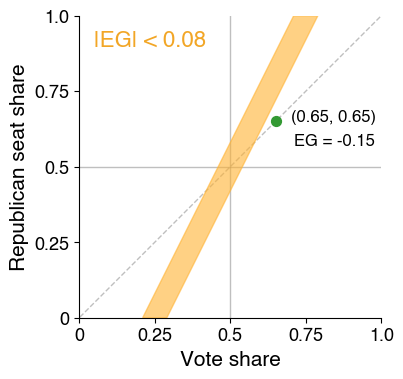

In [6]:
plot_eg_band()